<a id='Q0'></a>
<center> <h1> Notebook 1: Developing a Simple Webscraping Script </h1> </center>
<p style="margin-bottom:1cm;"></p>
<center><strong>Angela Niederberger, 2022</strong></center>
<p style="margin-bottom:1cm;"></p>

<div style="background:#EEEDF5;border-top:0.1cm solid #EF475B;border-bottom:0.1cm solid #EF475B;">
    <div style="margin-left: 0.5cm;margin-top: 0.5cm;margin-bottom: 0.5cm;color:#303030">
        <p><strong>Goal:</strong> In this notebook I develop a python script to retrieve data on the most recent news items from the SRF website and save it in an AWS S3 bucket</p>
        <strong> Outline:</strong>
        <a id='P0' name="P0"></a>
        <ol>
            <li> <a style="color:#303030" href='#I'>Introduction </a> </li>
            <li> <a style="color:#303030" href='#SU'>Set up</a></li>
            <li> <a style="color:#303030" href='#P1'>Retrieving the Data</a></li>
            <li> <a style="color:#303030" href='#P2'>Part 2</a></li>
            <li> <a style="color:#303030" href='#P3'>Part 3</a></li>
            <li> <a style="color:#303030" href='#CL'>Conclusion</a></li>
        </ol>
        <strong>Keywords:</strong> Webscraping, BeautifulSoup, AWS
    </div>
</div>
</nav>

<a id='I' name="I"></a>
## [Introduction](#P0)

In this notebook I first explored the following steps:
- how to retrieve data from a website using BeautifulSoup
- performing basic cleaning tasks on this data
- saving it to an AWS S3 Bucket

Then I rewrote my code to create a Python script that can be automated.

<a id='SU' name="SU"></a>
## [Set up](#P0)

I created a virtual environment and installed Python 3.10.4 in it for this project. Below are the specifics on all the packages I used. I've also summarized all of this information in the requirements file.

### Packages

In [1]:
# Retrieving & Wrangling Data
import requests  # Version 2.27.1
from bs4 import BeautifulSoup  # Version 4.11.1
import pandas as pd  # Version 1.4.2
from datetime import date  # Built-in Python library

# Saving the Data
import s3fs  # Version 2022.5.0

### Magic Commands

In [2]:
%config Completer.use_jedi = False

<a id='P1'></a>
## [Retrieving the Data](#P0)

In this first section I use requests and BeautifulSoup to retrieve data on news items from the SRF website. Then I wrangle the data into the desired format with Pandas.

### Webscraping

Below is a simple webscraping script which serves to extract the publishing time and teaser data of all news articles found on https://www.srf.ch/news/das-neueste on any specific day.

Here's an excellent ressource for more information on webscraping: https://realpython.com/beautiful-soup-web-scraper-python/.

In [3]:
# This is the static page to scrape
URL = "https://www.srf.ch/news/das-neueste"
page = requests.get(URL)

# Then parse it
soup = BeautifulSoup(page.content, "html.parser")

# Get the different elements
teaser_lists = soup.find_all("div", class_="js-teaser-data")
kickers = soup.find_all("span", class_="teaser__kicker-text")
titles = soup.find_all("span", class_="teaser__title")
leads = soup.find_all("p", class_="teaser__lead")

# Iterate through the elements and extract the relevant information
news_snippet_dict = {
    "time_published": [],
    "kicker": [],
    "title": [],
    "lead": []
}

for (teaser_list, kicker, title, lead) in zip(teaser_lists, kickers, titles, leads):
    news_snippet_dict["time_published"].append(teaser_list.get("data-date-published"))
    news_snippet_dict["kicker"].append(kicker.get_text())
    news_snippet_dict["title"].append(title.get_text())
    news_snippet_dict["lead"].append(lead.get_text())
    
news_snippets_df = pd.DataFrame(news_snippet_dict)
news_snippets_df.head()

,time_published,kicker,title,lead
0,2022-06-01T10:07:00+02:00,Rückkehr in die Super League,Itten unterschreibt bei YB,Cedric Itten wechselt von den Glasgow Rangers ...
1,2022-06-01T09:46:00+02:00,Mieterhöhungen ausgeschlossen,Referenzzinssatz für Wohnungsmieten bleibt bei...,Der rekordtiefe Wert hat sich laut Bundesamt f...
2,2022-06-01T08:50:00+02:00,Chinas Null-Covid-Politik,«Der Lockdown in Schanghai hat tiefe Narben hi...,Die Öffnungseuphorie in Chinas Metropole sei g...
3,2022-06-01T08:37:00+02:00,Schotten als erste Hürde,Die Ukraine kämpft um mehr als das WM-Ticket,In Glasgow wollen die Ukrainer in den WM-Playo...
4,2022-06-01T07:06:00+02:00,Playoff-Halbfinal in der NHL,Colorado Avalanche bezwingt die Oilers in eine...,Zum Auftakt der Playoff-Halbfinals in Nordamer...


### Data Wrangling

In [4]:
# Turn the publishing time into a timestamp
news_snippets_df["time_published"] = pd.to_datetime(news_snippets_df["time_published"])

# Select only news from this day
news_snippets_df = news_snippets_df[news_snippets_df["time_published"].dt.date==date.today()]

In [5]:
news_snippets_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11 entries, 0 to 10
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype                                
---  ------          --------------  -----                                
 0   time_published  11 non-null     datetime64[ns, pytz.FixedOffset(120)]
 1   kicker          11 non-null     object                               
 2   title           11 non-null     object                               
 3   lead            11 non-null     object                               
dtypes: datetime64[ns, pytz.FixedOffset(120)](1), object(3)
memory usage: 440.0+ bytes


<div style="background:#EEEDF5;color:#303030"><div style="margin-left: .2cm">
    <b>Comments:</b>
</div></div>

<div style="margin-left: 0.4cm">
    This Markdown cell is a template to write extended comments. e.g. explain the approach taken, or concepts behind algorithm chosen. Aim at having 2 lines at least. Anything smaller can be directly integrated in the code, or gathered together with other comments to form a bigger paragraph. Since this block is within a div element, you need to use html formatting syntax, not markdown
</div>

<div style="background:#EEEDF5;border:0.1cm solid #00BAE5;color:#303030">
    <div style="margin: 0.2cm 0.2cm 0.2cm 0.2cm">
        <b style="color:#00BAE5">Note:</b>
        This is an example Blue Box
    </div>
</div>

<a id='P2' name="P2"></a>
## [Saving the Data](#P0)

Sign up for an AWS account, create an Admin User and give the user access to the bucket. Follow these instructions: https://docs.aws.amazon.com/AmazonS3/latest/userguide/example-walkthroughs-managing-access-example1.html.

As a next step, I want to save the retrieved data to an AWS S3 Bucket. For this purpose, I had to create an AWS account here: https://aws.amazon.com/ and save the credentials on my computer. Then I created the bucket following these instructions: https://docs.aws.amazon.com/AmazonS3/latest/userguide/create-bucket-overview.html. The name of my bucket is `srf-news-snippets` and the region is `eu-central-1`. I kept the default options for all the other settings.

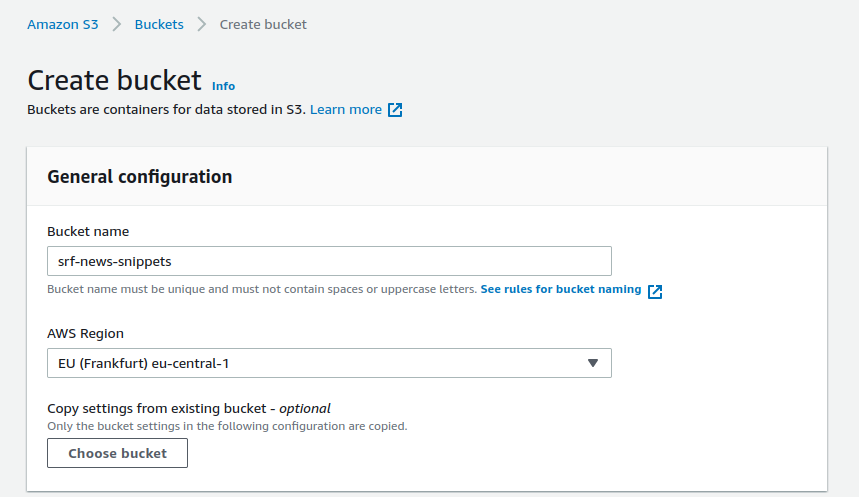

To stay organized, I created a `data` folder in my S3 Bucket (as is clear from the path I'm using below). Once all of this is done, so I can get started with the code below. I am using the S3fs package which is used specifically for working with S3 Buckets.

In [26]:
# Create connection to AWS S3 Bucket
fs = s3fs.S3FileSystem(anon=False)

# Define the path for the file
s3_folder_path = "s3://srf-news-snippets/data"
filename = f"{date.today()}_srf_news_snippets.csv"

# Save the file
news_snippets_df.to_csv(f"{s3_folder_path}/{filename}")

In [25]:
# Create connection to AWS S3 Bucket
fs = s3fs.S3FileSystem(anon=False)

fs.ls("s3://srf-news-snippets")

PermissionError: Access Denied

<a id='P2' name="P2"></a>
## [Code Refactor](#P0)

In [7]:
def scrape_srf_daily_news(URL):
    page = requests.get(URL)

    # Then parse it
    soup = BeautifulSoup(page.content, "html.parser")

    # Get the different elements
    teaser_lists = soup.find_all("div", 
                                 class_="js-teaser-data")
    kickers = soup.find_all("span", class_="teaser__kicker-text")
    titles = soup.find_all("span", class_="teaser__title")
    leads = soup.find_all("p", class_="teaser__lead")

    # Iterate through the elements and extract the relevant information
    news_snippet_dict = {
        "time_published": [],
        "kicker": [],
        "title": [],
        "lead": []
    }

    for (teaser_list, kicker, title, lead) in zip(teaser_lists, kickers, titles, leads):
        news_snippet_dict["time_published"].append(teaser_list.get("data-date-published"))
        news_snippet_dict["kicker"].append(kicker.get_text())
        news_snippet_dict["title"].append(title.get_text())
        news_snippet_dict["lead"].append(lead.get_text())

    news_snippets_df = pd.DataFrame(news_snippet_dict)
    
    # Turn the publishing time into a timestamp
    news_snippets_df["time_published"] = pd.to_datetime(news_snippets_df["time_published"])

    # Select only news from this day
    news_snippets_df = news_snippets_df[news_snippets_df["time_published"].dt.date==
                                        date.today()]
    
    return news_snippets_df

<a id='CL'></a>
## [Conclusion](#P0)

This is a pre-written conclusion in which we have nice figures.

<div style="border-top:0.1cm solid #EF475B"></div>
    <strong><a href='#Q0'><div style="text-align: right"> <h3>End of this Notebook.</h3></div></a></strong>